In [32]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
%pip install geocoder
%pip install geopy
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Libraries imported.


In [73]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [74]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = '3QTWJPM4CVSCYN1GTGSZR4M3JHXWNWAPXADO55Z1DVP0N03B'
    CLIENT_SECRET = 'W1TLPE1EQNSAECLS2OJUNPIPH0VPOEWRE1USFGSSBOHP2K1J'
    VERSION = '20180605' 
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [76]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [77]:
new_york_data=get_new_york_data()

In [78]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [52]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
ita_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    ita_resturants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Italian Resturants in '+Neighborhood+', '+Borough+':'+str(len(ita_resturants)))
    for resturant_detail in ita_resturants.values.tolist():
        id, name , category=resturant_detail
        ita_rest_ny = ita_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Italian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Italian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Italian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Italian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Italian Resturants in Riverdale, Bronx:1
( 6 / 306 ) Italian Resturants in Kingsbridge, Bronx:1
( 7 / 306 ) Italian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Italian Resturants in Woodlawn, Bronx:2
( 9 / 306 ) Italian Resturants in Norwood, Bronx:0
( 10 / 306 ) Italian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Italian Resturants in Baychester, Bronx:2
( 12 / 306 ) Italian Resturants in Pelham Parkway, Bronx:3
( 13 / 306 ) Italian Resturants in City Island, Bronx:3
( 14 / 306 ) Italian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Italian Resturants in University Heights, Bronx:0
( 16 / 306 ) Italian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Italian Resturants in Fordham, Bronx:9
( 18 / 306 ) Italian Resturants in East Tremont, Bronx:

In [55]:
ita_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Riverdale,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria
1,Bronx,Kingsbridge,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria
2,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn
3,Bronx,Woodlawn,4d3cb3026b3d236a066a6364,Rivers Edge
4,Bronx,Baychester,4c9518076b35a143d5dc21dc,Fratelli's


In [57]:
ita_rest_ny.shape

(536, 4)

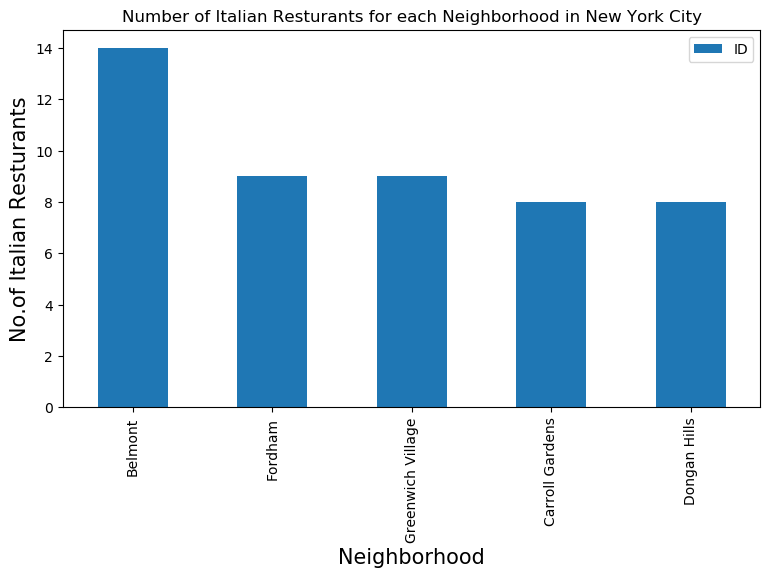

In [60]:
plt.figure(figsize=(9,5), dpi = 100)

plt.title('Number of Italian Resturants for each Neighborhood in New York City')
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No.of Italian Resturants', fontsize=15)
ita_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
plt.legend()
plt.show()

In [112]:
ita_rest_ny[ita_rest_ny['Neighborhood']=='Belmont'] #is the largest neighborhood

,Borough,Neighborhood,ID,Name
43,Bronx,Belmont,4acf80aef964a52025d420e3,Tino's Delicatessen
44,Bronx,Belmont,4bb6470cef159c7465b275f7,Calabria Pork Store
45,Bronx,Belmont,4af0fa29f964a52060e021e3,Antonio's Trattoria
46,Bronx,Belmont,59050f51b23dfa5f6649e678,Arthur Avenue Fiasco
47,Bronx,Belmont,4aa425bef964a5208e4520e3,Dominick's Restaurant
48,Bronx,Belmont,4b5514c4f964a5207cda27e3,Enzo's
49,Bronx,Belmont,4a8e261cf964a5201c1220e3,Roberto's
50,Bronx,Belmont,4af71916f964a520cf0522e3,Michaelangelo's Coal Fired Brick Oven Pizza Re...
51,Bronx,Belmont,4aa193d5f964a520124120e3,Mario's Restaurant & Catering
52,Bronx,Belmont,4c79d294278eb713f6a05580,Cafe al Mercato


In [120]:
ita_rest_ny.groupby('Borough').count()

,Neighborhood,ID,Name
Borough,,,
Bronx,83,83,83
Brooklyn,116,116,116
Manhattan,126,126,126
Queens,101,101,101
Staten Island,110,110,110


## conclusion

the neighborhood with the most Italian restaurants is Belmont, while the borough with the highest number of Italian restaurants is Manhattan